In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dataclasses import dataclass

import numpy as np
import matplotlib.pyplot as plt
from cw.context import time_it
from cw.simulation import Simulation, StatesBase, AB3Integrator, ModuleBase, Logging, Plotter

from topone.environment import Environment, Stage, StageState

In [9]:
@dataclass
class States(StatesBase):
    t: float = 0
    command_engine_on: bool = False
    command_drop_stage: bool = False
    gii: np.ndarray = np.zeros(2)
    xii: np.ndarray = np.zeros(2)
    vii: np.ndarray = np.zeros(2)
    aii: np.ndarray = np.zeros(2)
    fii_thrust: np.ndarray = np.zeros(2)
    theta: float = 0
    theta_dot: float = 0
    mass: float = 0
    mass_dot: float = 0
    engine_on: bool = False
    stage_state: StageState = StageState.unfired
    stage_idx: int = 0

    def get_y_dot(self):
        return np.hstack([
            self.vii,
            self.aii,
            self.theta_dot,
            self.mass_dot
        ])

    def get_y(self):
        return np.hstack([
            self.xii,
            self.vii,
            self.theta,
            self.mass,
        ])

    def set_t_y(self, t, y):
        self.t = t
        self.xii = y[:2]
        self.vii = y[2:4]
        self.theta = y[4]
        self.mass = y[5]

In [10]:
simulation = Simulation(
    states_class=States,
    integrator=AB3Integrator(
        h=0.01,
        rk4=True,
        fd_max_order=1),
    modules=[
        Environment(
            surface_diameter=1737.4e3,
            mu=4.9048695e12,
            stages=(
                Stage(1, 1, 100, 3),
            ),
            initial_altitude=1000,
            initial_theta=0,
            initial_latitude=0,
        ),
    ],
    logging=Logging(),
    initial_state_values=None,
)

simulation.initialize()

In [11]:
with time_it("simulation run"):
    result = simulation.run(10000)

simulation run: 2.6318004349959665 [s]


In [12]:
result

<xarray.Dataset>
Dimensions:             (d_2_0: 2, t: 10000)
Coordinates:
  * t                   (t) float64 0.0 0.01 0.02 0.03 ... 99.97 99.98 99.99
Dimensions without coordinates: d_2_0
Data variables:
    command_engine_on   (t) bool False False False False ... False False False
    command_drop_stage  (t) bool False False False False ... False False False
    gii                 (t, d_2_0) float64 -1.623 -0.0 -1.623 ... -1.638 -0.0
    xii                 (t, d_2_0) float64 1.738e+06 0.0 ... 1.73e+06 0.0
    vii                 (t, d_2_0) float64 0.0 0.0 -0.01623 ... 0.0 -162.8 0.0
    aii                 (t, d_2_0) float64 -1.623 0.0 -1.623 ... 0.0 -1.638 0.0
    fii_thrust          (t, d_2_0) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    theta               (t) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    theta_dot           (t) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    mass                (t) float64 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0
    mass_dot            (t) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    engine_on           (t) bool False False False False ... False False False
    stage_state         (t) object StageState.unfired ... StageState.unfired
    stage_idx           (t) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0

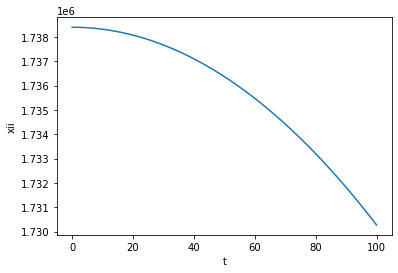

In [13]:
result.xii.sel(d_2_0=0).plot()

In [16]:
result.gii.sel(t=0, d_2_0=0).item()
result.t

<xarray.DataArray 't' (t: 10000)>
array([0.000e+00, 1.000e-02, 2.000e-02, ..., 9.997e+01, 9.998e+01, 9.999e+01])
Coordinates:
  * t        (t) float64 0.0 0.01 0.02 0.03 0.04 ... 99.96 99.97 99.98 99.99

In [21]:
dx = 0.5 * -1.6230355419893014 * 100**2
dx

-8115.177709946507

In [20]:
result.xii.sel(d_2_0=0).min() - result.xii.sel(d_2_0=0).max()

<xarray.DataArray 'xii' ()>
array(-8126.22082498)